# Overview

This notebook provides an example usage for using bm3dornl to remove streaks from single sinogram.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

when on a multi-gpu system, make sure specify the card you are using to avoid affecting other people's job

In [2]:
import os

# Set the GPU device ID to 0 for this notebook session
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

## Prepare synthetic noisy sinogram

In [3]:
from bm3dornl.phantom import (
    shepp_logan_phantom,
    generate_sinogram,
    simulate_detector_gain_error,
)

In [4]:
# define image size
image_size = 512  # smaller size runs faster on local machine, large number means wider image
scan_step = 0.5  # deg, smaller number means taller image
detector_gain_range=(0.98, 1.02)  # variation along detector width
detector_gain_error=0.01  # variation along time/rotation

In [5]:
%%time

# make shepp_logan 2D phantom
shepp_logan_2d = shepp_logan_phantom(
    size=image_size,
    contrast_factor=8,
    )

# transform to sinogram
sino_org, thetas_deg = generate_sinogram(
    input_img=shepp_logan_2d,
    scan_step=scan_step,
    )

# add detector gain error
sino_noisy, detector_gain = simulate_detector_gain_error(
    sinogram=sino_org,
    detector_gain_range=detector_gain_range,
    detector_gain_error=detector_gain_error,
)

CPU times: user 3.17 s, sys: 26.9 ms, total: 3.19 s
Wall time: 3.22 s


visualization

(512, 512) (720, 512) (720, 512)
1e-08 1.0


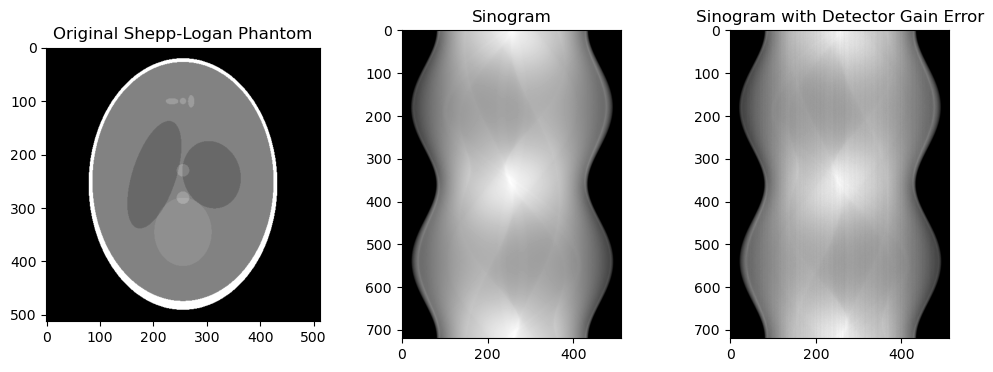

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(shepp_logan_2d, cmap='gray')
ax[0].set_title('Original Shepp-Logan Phantom')
ax[1].imshow(sino_org, cmap='gray')
ax[1].set_title('Sinogram')
ax[2].imshow(sino_noisy, cmap='gray')
ax[2].set_title('Sinogram with Detector Gain Error')

print(shepp_logan_2d.shape, sino_org.shape, sino_noisy.shape)
print(sino_noisy.min(), sino_noisy.max())

estimate background

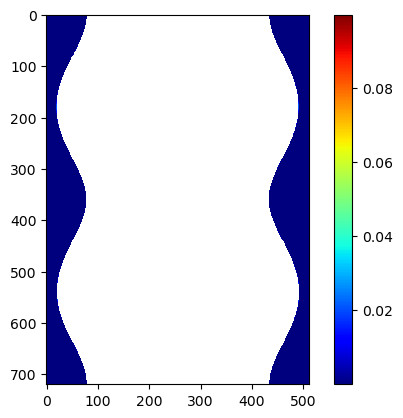

In [7]:
bg_estimate = 0.1

bg = np.array(sino_noisy)
bg[sino_noisy >= bg_estimate] = np.nan
#
plt.imshow(bg, cmap="jet")
plt.colorbar()
plt.show()

## BM3D close source version

In [8]:
import bm3d_streak_removal as bm3dsr

In [9]:
%%time

sion_bm3d_attenuated = bm3dsr.extreme_streak_attenuation(
    data=sino_noisy,
    extreme_streak_iterations=3,
    extreme_detect_lambda=4.0,
    extreme_detect_size=9,
    extreme_replace_size=2,
)

Median filtering, iteration 0
Median filtering, iteration 1
Median filtering, iteration 2
CPU times: user 3.39 s, sys: 27.7 ms, total: 3.42 s
Wall time: 3.42 s


In [10]:
%%time

sino_bm3d = bm3dsr.multiscale_streak_removal(
    data=sion_bm3d_attenuated,
    max_bin_iter_horizontal=0,
    bin_vertical=0,
    filter_strength=1.0,
    use_slices=True,
    slice_sizes=None,
    slice_step_sizes=None,
    denoise_indices=None,
)

Denoising sinogram 0
k: 0
CPU times: user 2min 53s, sys: 1min 11s, total: 4min 4s
Wall time: 57.2 s


In [11]:
sion_bm3d_attenuated = sion_bm3d_attenuated[:, 0, :]
sino_bm3d = sino_bm3d[:, 0, :]

visualization

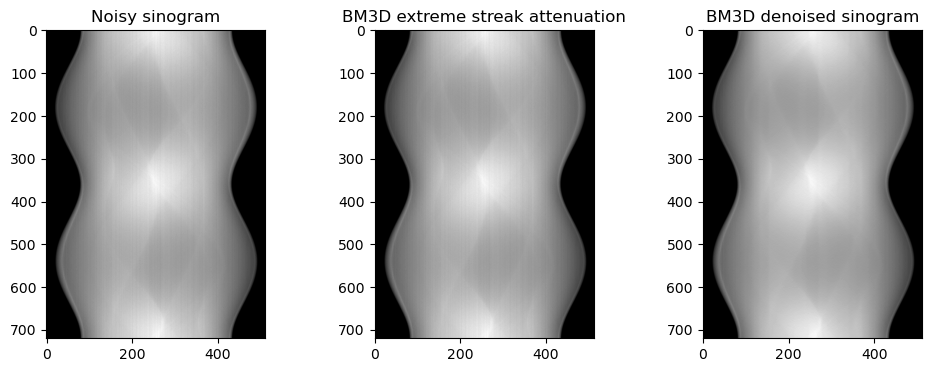

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(sino_noisy, cmap='gray')
axs[0].set_title('Noisy sinogram')
axs[1].imshow(sion_bm3d_attenuated, cmap='gray')
axs[1].set_title('BM3D extreme streak attenuation')
axs[2].imshow(sino_bm3d, cmap='gray')
axs[2].set_title('BM3D denoised sinogram')
plt.show()

## BM3DRONL

In [13]:
from bm3dornl.denoiser import bm3d_streak_removal

In [14]:
%%time

sino_bm3dornl = bm3d_streak_removal(
    sinogram=sino_noisy,
    background_threshold=0.1,
    patch_size=(8, 8),
    stride=3,
    cut_off_distance=(128, 128),
    intensity_diff_threshold=0.2,
    num_patches_per_group=300,
    shrinkage_threshold=1 - 1e-4,
    k=0,
)

CPU times: user 2min 43s, sys: 4.55 s, total: 2min 48s
Wall time: 2min 48s


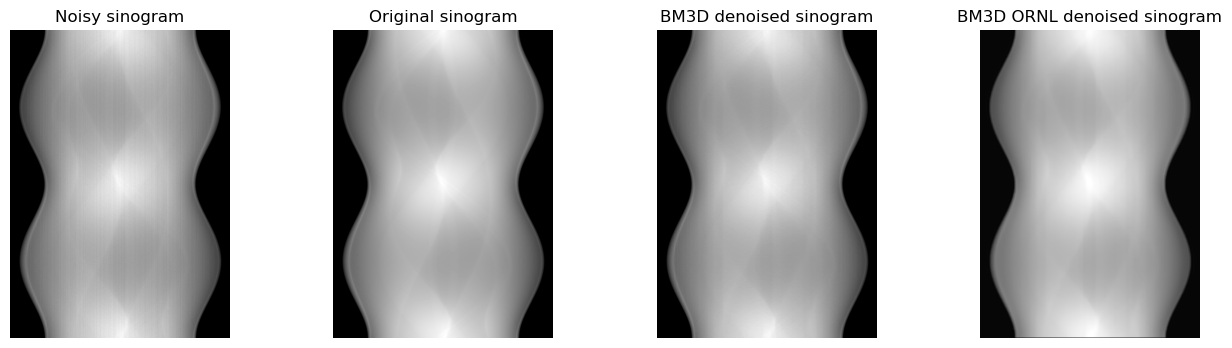

In [15]:
# visualize noisy, org, sino_bm3d, and sino_bm3dornl
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].imshow(sino_noisy, cmap='gray')
axs[0].set_title('Noisy sinogram')
axs[0].axis('off')
axs[1].imshow(sino_org, cmap='gray')
axs[1].set_title('Original sinogram')
axs[1].axis('off')
axs[2].imshow(sino_bm3d, cmap='gray')
axs[2].set_title('BM3D denoised sinogram')
axs[2].axis('off')
axs[3].imshow(sino_bm3dornl, cmap='gray')
axs[3].set_title('BM3D ORNL denoised sinogram')
axs[3].axis('off')
plt.show()